In [34]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict
from PIL import Image
from scipy import ndimage
import pandas as pd
import imageio
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16

from datetime import datetime
from packaging import version

%matplotlib inline

In [35]:
# labels = np.genfromtxt('labels.csv', delimiter=',')
labels = pd.read_csv('labels.csv', float_precision='road_trip')
labels.head(5)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14740401517634903151
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13445494985884326059
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11862855410478731682
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14912199066
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13989892995877268992
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5"
]


In [36]:
labels["base color R"] = labels["base color R"].str[1:]
labels["base color B"] = labels["base color B"].str[:-1]
labels["specular color R"] = labels["specular color R"].str[1:]
labels["specular color B"] = labels["specular color B"].str[:-1]
labels["img_name"] = labels["img_name"].str[:-3]+"jpg"

In [37]:
labels.head(5)

,Unnamed: 0,img_name,base,base color R,base color G,base color B,specular,specular color R,specular color G,specular color B,specular roughness,metalness
0,0,0.jpg,0.196696,0.02551167982996516,0.523569,0.09533690194549593,0.903675,0.9414576345001383,0.927580,0.418087362819755,0.120439,0.941755
1,1,1.jpg,0.563387,0.13560656102894886,0.715835,0.6311335628961977,0.381407,0.9228773407900674,0.328530,0.294482323738513,0.439152,0.511734
2,2,2.jpg,0.433630,0.06292513279208145,0.468129,0.49781547380782,0.622876,0.8260393377700712,0.115993,0.1549741111822439,0.646591,0.490058
3,3,3.jpg,0.471443,0.8909351516333082,0.133360,0.7187711144029106,0.419356,0.08579008506320773,0.466882,0.36951439970192435,0.154928,0.632136
4,4,4.jpg,0.172493,0.1089380911674539,0.179026,0.4079338804909298,0.893968,0.9620524644071147,0.906355,0.3523653506316685,0.708425,0.002353


In [38]:
vector_values = labels.iloc[:,2:]
vector_values = vector_values.astype(float)
vector_values.head(5)

,base,base color R,base color G,base color B,specular,specular color R,specular color G,specular color B,specular roughness,metalness
0,0.196696,0.025512,0.523569,0.095337,0.903675,0.941458,0.927580,0.418087,0.120439,0.941755
1,0.563387,0.135607,0.715835,0.631134,0.381407,0.922877,0.328530,0.294482,0.439152,0.511734
2,0.433630,0.062925,0.468129,0.497815,0.622876,0.826039,0.115993,0.154974,0.646591,0.490058
3,0.471443,0.890935,0.133360,0.718771,0.419356,0.085790,0.466882,0.369514,0.154928,0.632136
4,0.172493,0.108938,0.179026,0.407934,0.893968,0.962052,0.906355,0.352365,0.708425,0.002353


In [39]:
np_labels = vector_values.values
np_labels[0]

array([0.19669609, 0.02551168, 0.52356934, 0.0953369 , 0.90367509,
       0.94145763, 0.92757973, 0.41808736, 0.1204395 , 0.94175506])

THE BELOW CELL TAKES AGES TO RUN. ONLY RUN IT ONCE.

(855, 1280, 3)

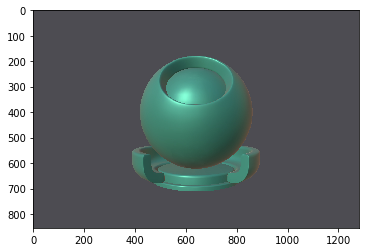

In [40]:
fname = "./data_split/train_data/train/1.jpg"
arr = np.array(imageio.imread(fname))
plt.imshow(arr)
arr.shape

In [41]:
BATCH_SIZE = 40
IMG_HEIGHT = 855
IMG_WIDTH = 1280
STEPS_PER_EPOCH = np.ceil(4000/BATCH_SIZE) 

In [49]:
def crop(img):
    # Note: image_data_format is 'channel_last'
    x = 
    y = 0
    crop_size = 224
    return img[y:(y+crop_size), x:(x + crop_size), :]

def label_gen(labels, batch_size):
    num = 0
    while True:
        yield labels[num: num + BATCH_SIZE, :]
        num += batch_size
        if (num >= len(labels)):
            num = 0
    
def crop_gen(batches, labels):
    while True:
        batch_x = next(batches)
        batch_crops = np.zeros((BATCH_SIZE, 855, 855, 3))
        for i in range(BATCH_SIZE):
            batch_crops[i] = crop(batch_x[0][i])
        tf_batch = tf.convert_to_tensor(batch_crops)
        
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [50]:
# 90 percent split
train_data_gen = image_generator.flow_from_directory(directory=str("./data_split/train_data"),
                                                     target_size=(IMG_HEIGHT * .4, IMG_WIDTH * .4),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle = False,
                                                     classes = None)
test_data_gen = image_generator.flow_from_directory(directory=str("./data_split/test_data"),
                                                     target_size=(IMG_HEIGHT * .4, IMG_WIDTH * .4),
                                                     batch_size=BATCH_SIZE,
                                                     classes = None)

Found 6500 images belonging to 1 classes.
Found 2000 images belonging to 1 classes.


In [51]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.axis('off')

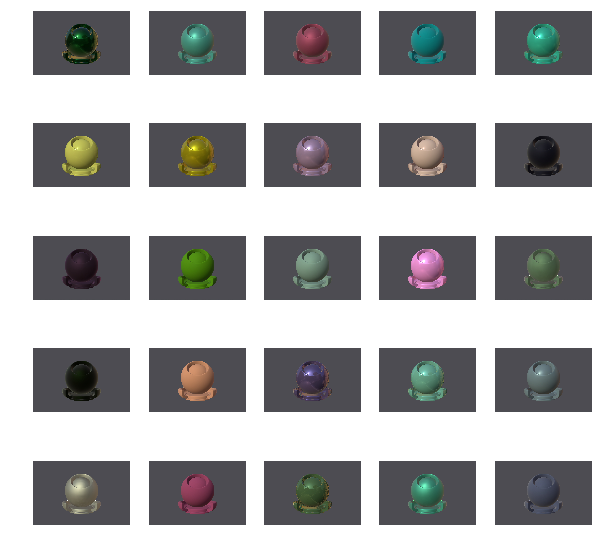

In [52]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [53]:
Y_train = np_labels[:3600]
Y_test = np_labels[3600:]
Y_train_gen = label_gen(Y_train, BATCH_SIZE)
Y_test_gen = label_gen(Y_test, BATCH_SIZE)

In [47]:
initial_model = VGG16(weights='imagenet', include_top=False)

for layer in initial_model.layers:
    layer.trainable = False

#output_layer = initial_model.get_layer('fc2')

#x = layers.Flatten(input_shape=(7, 7, 512))(output)
#x.set_shape((None, 12088))
preds = layers.Flatten()(initial_model.output)
preds.set_shape((None, 25088))
preds = layers.Dense(10, activation='sigmoid', input_shape=(None, 25088), trainable=True)(preds)

model = keras.Model(initial_model.input, preds)

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [54]:
train_crops = crop_gen(train_data_gen, Y_train_gen)
test_crops = crop_gen(test_data_gen, Y_test_gen)

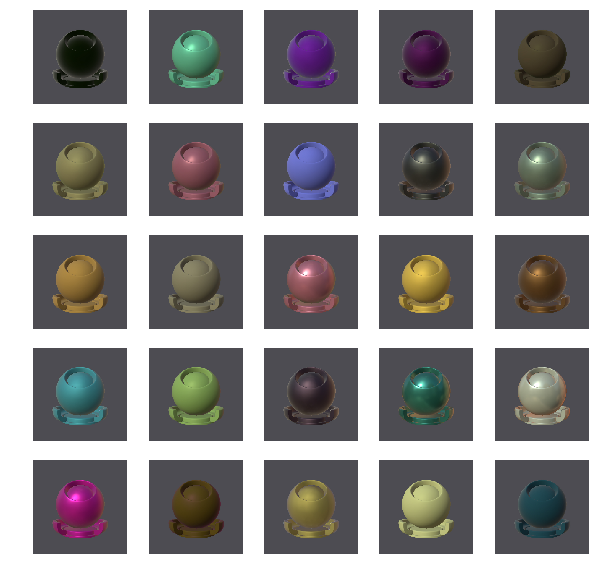

In [57]:
image_batch, label_batch = next(train_crops)
show_batch(tf.Session().run(image_batch), label_batch)

In [ ]:
# Define the Keras TensorBoard callback.
logdir="logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
STEP_SIZE_TRAIN=train_data_gen.n//train_data_gen.batch_size
STEP_SIZE_VALID=test_data_gen.n//test_data_gen.batch_size

model.fit_generator(generator=train_crops,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_crops,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10,
                    max_queue_size=10, 
                    workers=1, 
                    use_multiprocessing=False,
                    callbacks=[]
)

In [ ]:
parameters = model(train_data_gen, Y_train, test_data_gen, Y_test)